In [302]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error,mean_absolute_percentage_error
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
%matplotlib inline


In [303]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [304]:
# Hàm chuyển đổi dữ liệu time-series
def df_to_X_y(df, feature_cols, target_col, window_size=60):
    # Chỉ sử dụng các cột cần thiết
    data = df[feature_cols + [target_col]].values

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Xử lý dữ liệu thành X, y với sliding window
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])  # Các cột feature
        y.append(data[i + window_size, -1])    # Cột target
    return np.array(X), np.array(y), scaler

In [305]:
# Dataset xử lý dữ liệu
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
# Hàm tạo DataLoader
def preprocess_data(df, feature_cols, target_col, window_size=60, batch_size=32):
    # Sử dụng df_to_X_y để tạo dữ liệu
    X, y, scaler = df_to_X_y(df, feature_cols, target_col, window_size)
    
    # Chuyển đổi sang Tensor
    dataset = CustomDataset(torch.tensor(X, dtype=torch.float32), 
                            torch.tensor(y, dtype=torch.float32))
    
    # Tạo DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Trả về DataLoader và scaler
    return dataloader, scaler


In [306]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, bidirectional=True):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.output_size = output_size
        self.bidirectional = bidirectional
        
        # Step 1: Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True, bidirectional=bidirectional)
        
        # Step 2: Define Fully Connected layer
        if bidirectional:
            self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply hidden_size by 2 for bidirectional
        else:
            self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, sequences, prints=False):
        if prints: print('Input shape:', sequences.shape)
        
        # Initialize hidden and cell states
        if self.bidirectional:
            h_0 = torch.zeros(self.layer_size * 2, sequences.size(0), self.hidden_size).to(sequences.device)
            c_0 = torch.zeros(self.layer_size * 2, sequences.size(0), self.hidden_size).to(sequences.device)
        else:
            h_0 = torch.zeros(self.layer_size, sequences.size(0), self.hidden_size).to(sequences.device)
            c_0 = torch.zeros(self.layer_size, sequences.size(0), self.hidden_size).to(sequences.device)
        
        if prints: print('Initial hidden state shape:', h_0.shape)
        
        # Step 3: LSTM computation
        output, (h_n, c_n) = self.lstm(sequences, (h_0, c_0))
        if prints:
            print('LSTM output shape:', output.shape)
            print('LSTM last hidden state shape:', h_n.shape)
            print('LSTM last cell state shape:', c_n.shape)
        
        # Step 4: Take the output of the last time step
        output = output[:, -1, :]  # Extract the last output for the sequence
        if prints: print('Last output shape:', output.shape)
        
        # Step 5: Fully connected layer
        output = self.fc(output)
        if prints: print('Final output shape:', output.shape)
        
        return output

In [307]:
# def model()
df = pd.read_csv(r'../data_model/ACB.csv')
# df.columns
df.set_index('Date', inplace=True)

feature_cols = [
    'SP_500', 'VN_30', 'VN_Index', 'VN_Index_volum', 
    'XAU_USD', 'XAU_USD_volum', 'USD_VND', 'USD_VND_volum', 
    'Gold', 'Gold_volum', 'Oil', 'Oil_volum', 'Bitcoin', 'Bitcoin_volum'
]
target_col = 'ACB'

input_size = len(feature_cols)  # Số đặc trưng đầu vào
print(f"Feature columns: {feature_cols}")
print(f"Input size: {input_size}")
print(f"Target column: {target_col}")

Feature columns: ['SP_500', 'VN_30', 'VN_Index', 'VN_Index_volum', 'XAU_USD', 'XAU_USD_volum', 'USD_VND', 'USD_VND_volum', 'Gold', 'Gold_volum', 'Oil', 'Oil_volum', 'Bitcoin', 'Bitcoin_volum']
Input size: 14
Target column: ACB


In [308]:

train_data = df[:750]
test_data = df[750:]

# Tạo DataLoader
train_loader, scaler = preprocess_data(train_data, feature_cols, target_col)
test_loader, _ = preprocess_data(test_data, feature_cols, target_col)

In [309]:
# Cấu hình mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_size = 128
layer_size = 2
output_size = 1
model = LSTM(input_size, hidden_size, layer_size, output_size, bidirectional=True).to(device)

# Loss và optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # print(x)
        outputs = model(x)
        loss = criterion(outputs, y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')


Epoch [1/50], Loss: 0.0631
Epoch [2/50], Loss: 0.0230
Epoch [3/50], Loss: 0.0204
Epoch [4/50], Loss: 0.0202
Epoch [5/50], Loss: 0.0216
Epoch [6/50], Loss: 0.0196
Epoch [7/50], Loss: 0.0197
Epoch [8/50], Loss: 0.0193
Epoch [9/50], Loss: 0.0191
Epoch [10/50], Loss: 0.0190
Epoch [11/50], Loss: 0.0183
Epoch [12/50], Loss: 0.0184
Epoch [13/50], Loss: 0.0183
Epoch [14/50], Loss: 0.0172
Epoch [15/50], Loss: 0.0215
Epoch [16/50], Loss: 0.0190
Epoch [17/50], Loss: 0.0186
Epoch [18/50], Loss: 0.0175
Epoch [19/50], Loss: 0.0179
Epoch [20/50], Loss: 0.0183
Epoch [21/50], Loss: 0.0164
Epoch [22/50], Loss: 0.0157
Epoch [23/50], Loss: 0.0160
Epoch [24/50], Loss: 0.0158
Epoch [25/50], Loss: 0.0132
Epoch [26/50], Loss: 0.0138
Epoch [27/50], Loss: 0.0132
Epoch [28/50], Loss: 0.0125
Epoch [29/50], Loss: 0.0138
Epoch [30/50], Loss: 0.0130
Epoch [31/50], Loss: 0.0130
Epoch [32/50], Loss: 0.0121
Epoch [33/50], Loss: 0.0106
Epoch [34/50], Loss: 0.0104
Epoch [35/50], Loss: 0.0138
Epoch [36/50], Loss: 0.0128
E

Test MSE: 0.0934 Test MSE: 0.3055 R2 Score: -1.1547 MAPE: 9594496614400.0000


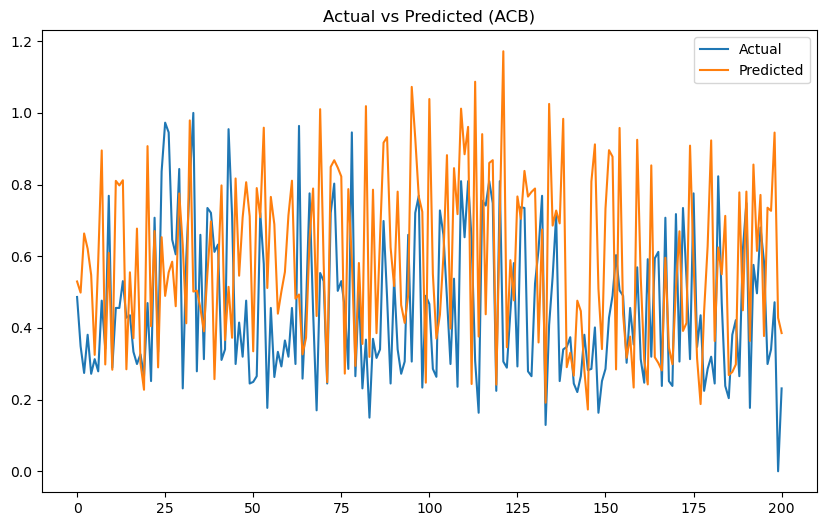

In [310]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)  # [batch_size, 1]
        y_pred.extend(outputs.squeeze().cpu().numpy())  # Chuyển về 1 chiều
        y_true.extend(y.cpu().numpy())

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)

r2 = r2_score(y_true, y_pred)
print(f"Test MSE: {mse:.4f}", f"Test MSE: {rmse:.4f}", f"R2 Score: {r2:.4f}", f"MAPE: {mape:.4f}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted (ACB)")
plt.show()


Test MSE: 18250010.0773 Test MSE: 4272.0031 R2 Score: -1.1547 MAPE: 0.1694


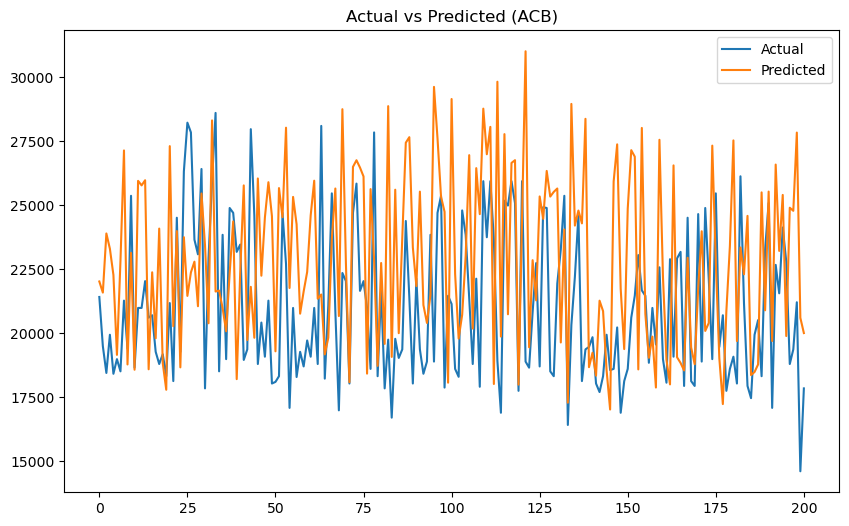

In [311]:
if scaler:
    y_true_original = scaler.inverse_transform(
        [[0] * (scaler.n_features_in_ - 1) + [val] for val in y_true]
    )[:, -1]
    y_pred_original = scaler.inverse_transform(
        [[0] * (scaler.n_features_in_ - 1) + [val] for val in y_pred]
    )[:, -1]
else:
    y_true_original = y_true
    y_pred_original = y_pred

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_true_original, y_pred_original)
rmse = root_mean_squared_error(y_true_original, y_pred_original)
r2 = r2_score(y_true_original, y_pred_original)
mape = mean_absolute_percentage_error(y_true_original, y_pred_original)

print(f"Test MSE: {mse:.4f}", f"Test MSE: {rmse:.4f}", f"R2 Score: {r2:.4f}", f"MAPE: {mape:.4f}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(y_true_original, label="Actual")
plt.plot(y_pred_original, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted (ACB)")
plt.show()

In [ ]:
import joblib

def run_model_for_target(df, feature_cols, target_col, model_save_path, results_save_path):
    """
    Hàm chạy mô hình LSTM cho một cột mục tiêu cụ thể và lưu kết quả, chỉ số và mô hình.

    Args:
        df (pd.DataFrame): Dữ liệu đầu vào.
        feature_cols (list): Danh sách các cột đặc trưng.
        target_col (str): Tên cột mục tiêu.
        model_save_path (str): Đường dẫn lưu mô hình.
        results_save_path (str): Đường dẫn lưu kết quả.

    Returns:
        dict: Chứa các chỉ số đánh giá và đường dẫn lưu kết quả.
    """
    input_size = len(feature_cols)
    train_data = df[:750]
    test_data = df[750:]

    # Tạo DataLoader
    train_loader, scaler = preprocess_data(train_data, feature_cols, target_col)
    test_loader, _ = preprocess_data(test_data, feature_cols, target_col)

    # Cấu hình mô hình
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hidden_size = 128
    layer_size = 2
    output_size = 1
    model = LSTM(input_size, hidden_size, layer_size, output_size, bidirectional=True).to(device)

    # Loss và optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Huấn luyện
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

    # Đánh giá mô hình
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            y_pred.extend(outputs.squeeze().cpu().numpy())
            y_true.extend(y.cpu().numpy())

    # Scale ngược lại dữ liệu
    y_true_original = scaler.inverse_transform(
        [[0] * (scaler.n_features_in_ - 1) + [val] for val in y_true]
    )[:, -1]
    y_pred_original = scaler.inverse_transform(
        [[0] * (scaler.n_features_in_ - 1) + [val] for val in y_pred]
    )[:, -1]

    # Tính toán các chỉ số đánh giá
    mse = mean_squared_error(y_true_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_original, y_pred_original)
    mape = mean_absolute_percentage_error(y_true_original, y_pred_original)

    print(f"Test MSE: {mse:.4f}", f"Test RMSE: {rmse:.4f}", f"R2 Score: {r2:.4f}", f"MAPE: {mape:.4f}")

    # Lưu mô hình
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Lưu kết quả
    results = {
        "y_true": y_true_original.tolist(),
        "y_pred": y_pred_original.tolist(),
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "mape": mape
    }
    joblib.dump(results, results_save_path)
    print(f"Results saved to {results_save_path}")

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.plot(y_true_original, label="Actual")
    plt.plot(y_pred_original, label="Predicted")
    plt.legend()
    plt.title(f"Actual vs Predicted ({target_col})")
    plt.show()

    return results


results = run_model_for_target(
    df,
    feature_cols=[
        'SP_500', 'VN_30', 'VN_Index', 'VN_Index_volum', 
        'XAU_USD', 'XAU_USD_volum', 'USD_VND', 'USD_VND_volum', 
        'Gold', 'Gold_volum', 'Oil', 'Oil_volum', 'Bitcoin', 'Bitcoin_volum'
    ],
    target_col='ACB',
    model_save_path='lstm_model_acb.pth',
    results_save_path='results_acb.pkl'
)